In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DOWNLOAD_PATH = "./data/temp/"
DATA_PATH = "./data"
ZIP_NAME = "fer2013.zip"
TEMP_ZIP_FILE_PATH = os.path.join(DOWNLOAD_PATH, ZIP_NAME)
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [3]:
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

!curl -L -o {TEMP_ZIP_FILE_PATH} https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013

with zipfile.ZipFile(TEMP_ZIP_FILE_PATH, "r") as zip:
    zip.extractall(DATA_PATH)

os.remove(TEMP_ZIP_FILE_PATH)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.3M  100 60.3M    0     0  7964k      0  0:00:07  0:00:07 --:--:-- 10.3M


In [3]:
def load_dataset(PATH, img_size=96):
    CLASS_NAMES = sorted(os.listdir(PATH))
    LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    
    images = []
    labels = []
    
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(PATH, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (img_size, img_size))
                images.append(img_resized)
                labels.append(LABEL_MAP[class_name])
    images = np.array(images)
    labels = np.array(labels)
    images, labels = shuffle(images, labels, random_state=42)
    return images, labels, LABEL_MAP

In [4]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH, 300)
X_test, y_test, _ = load_dataset(TEST_PATH, 300)

X_train.shape, y_train.shape, LABEL_MAP

((28709, 300, 300, 3),
 (28709,),
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [5]:
X_train[0].shape

(300, 300, 3)

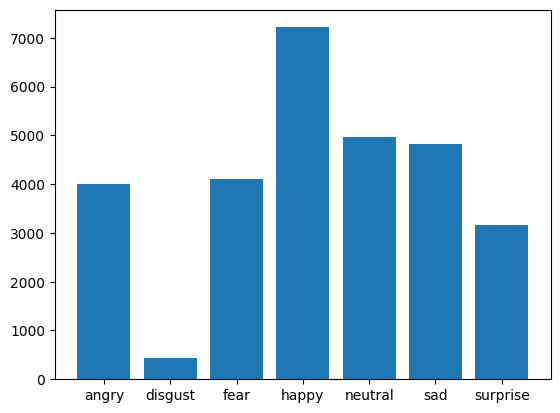

In [6]:
plt.bar(LABEL_MAP.keys(), np.bincount(y_train))
plt.show()

In [ ]:
import os
import tensorflow as tf

# Força o uso da GPU 0 (se houver mais de uma, escolha o índice)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Verifica se a GPU está disponível
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Habilita crescimento de memória para evitar alocação total
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Usando GPU: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("⚠ Nenhuma GPU encontrada, o treinamento será feito na CPU.")

# A partir daqui entra o código do modelo...
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np

IMG_SIZE = 96
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=len(LABEL_MAP))
y_test_cat = to_categorical(y_test, num_classes=len(LABEL_MAP))

print(X_test_resized.shape)

# Modelo base
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor
)
base_model.trainable = False

# Topo da rede
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(LABEL_MAP), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilação
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


2025-08-09 21:07:43.052882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibi

Usando GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Treinamento inicial (backbone congelado)
history = model.fit(
    X_train_resized, y_train_cat,
    validation_data=(X_test_resized, y_test_cat),
    epochs=60,
    batch_size=32
)

# # Fine-tuning
# base_model.trainable = True
# model.compile(optimizer=Adam(learning_rate=1e-5),
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

# history_ft = model.fit(
#     X_train_resized, y_train_cat,
#     validation_data=(X_test_resized, y_test_cat),
#     epochs=5,
#     batch_size=32
# )